In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm
import random
import math

tqdm.pandas(ascii=True)
%matplotlib inline

#https://networkx.github.io/documentation/networkx-1.7/tutorial/tutorial.html
# color: https://seaborn.pydata.org/tutorial/color_palettes.html

#sns.palplot(sns.color_palette("gist_rainbow", 10))

#nx.draw(G, pos, node_color=range(24), node_size=800, cmap=plt.cm.Blues)

In [2]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [3]:
df = pd.read_excel('./clincal_data.xlsx').fillna(0)
df['Patient_ID'] =  ['Patient%s' % str(i).zfill(2) for i in df.Patient_ID]

In [68]:
Root = 'ClinicalData'
Tissue = ['Cancer', 'Border', 'Normal']
Patients = ['Patient%s' % str(i).zfill(2) for i in range(1,2)]

Her2 = ['Her2', 'Her2-SHC', 'Her2-GRB2', 'Her2-GRB2-SHC']
ER =  ['ER','ER-GATA3','ER-FOXA1','ER-GATA3-FOXA1']
PR =  ['PR', 'PR-TIF2', 'PR-SRC1', 'PR-TIF2-SRC1']
SCRIB =  ['SCRIB','SCRIB-VANGL1','SCRIB-NOS1AP','SCRIB-VANGL1-NOS1AP']
WASF3 =  [ 'WASF3','WASF3-CYFIP1','WASF3-NCKAP1','WASF3-CYFIP1-NCKAP1']

SinglePro = {} #single pro
DoublePro = {} #two-complex
TriplePro = {} #three-complex

for i in [Her2, ER, PR, SCRIB, WASF3]: #Her2, ER, PR, SCRIB, WASF3
    s = i[0:1]
    d = i[1:3]
    t = i[-1:]
    n = i[0]
    SinglePro[n] = s
    DoublePro[n] = d
    TriplePro[n] = t
    
name = 'WASF3'

## Get Nodes, Edges

In [69]:
nodes0 = {}
nodes1 = {} #gene nodes, labels
nodes2 = {} #Tissue nodes, lables
nodes3 = {} #Single protein nodes, labels
nodes4 = {} #first Double protein nodes, labels
nodes44 = {} #second Double protein nodes2, labels
nodes5 = {} #Triple protein nodes, labels

edges1 = [] #gene edges
edges2 = [] #Tissue edges
edges3 = [] #Single Protien_edges
edges4 = [] #first Double Protien_edges
edges44 = [] #second Double Protien_edges
edges5 = [] #Triple Protien_edges


nodes0[Root] = Root

for i in SinglePro.keys():
    n1 = '%s_%s' % (Root, i)
    nodes1[n1] = i   
    edges1.append((Root, n1))
    
    for j in Tissue:
        n2 = '%s_%s_%s' % (Root, i, j)
        nodes2[n2] = j 
        edges2.append((n1, n2))
        
        for k in Patients:
            n3 = '%s_%s_%s_%s' % (Root, i, j, k)
            nodes3[n3] = i #name as single pro
            edges3.append((n2, n3))
            
            for idx, d in enumerate(DoublePro[i]):
                n4 = '%s_%s_%s_%s_%s' % (Root, i, j, k, d)
                if idx == 0:
                    nodes4[n4] = d
                    edges4.append((n3, n4))
                else:
                    nodes44[n4] = d
                    edges44.append((n3, n4))
                
                for t in TriplePro[i]:
                    n5 = '%s_%s_%s_%s_%s' % (Root, i, j, k,  t)
                    nodes5[n5] = t
                    edges5.append((n4, n5))       
            
nodes3_value = []
for k, v in nodes3.items():
    res = k.split('_')
    df1 = df[df.Patient_ID == res[3]]
    dft = df1[df1.Type == res[2]]
    exp = dft[res[-3]].iloc[0]
    nodes3_value.append(exp)
    
nodes4_value = []
for k, v in nodes4.items():
    res = k.split('_')
    df1 = df[df.Patient_ID == res[3]]
    dft = df1[df1.Type == res[2]]
    exp = dft[res[-1]].iloc[0]
    nodes4_value.append(exp)
    
nodes44_value = []
for k, v in nodes44.items():
    res = k.split('_')
    df1 = df[df.Patient_ID == res[3]]
    dft = df1[df1.Type == res[2]]
    exp = dft[res[-1]].iloc[0]
    nodes44_value.append(exp)
    
    
nodes5_value = []
for k, v in nodes5.items():
    res = k.split('_')
    df1 = df[df.Patient_ID == res[3]]
    dft = df1[df1.Type == res[2]]
    exp = dft[res[-1]].iloc[0]
    nodes5_value.append(exp)
    


## Graph object

In [70]:
G = nx.Graph()
# add nodes & edges
for nodes in [nodes0, nodes1, nodes2, nodes3, nodes4, nodes44,  nodes5]:
    G.add_nodes_from(nodes.keys())
for edges in [edges1, edges2, edges3, edges4, edges44, edges5]:
    G.add_edges_from(edges)
nx.is_tree(G)


False

## Layout

In [71]:

#layout = nx.spring_layout(G,iterations=500)
#layout = nx.layout.circular_layout(G)
# pos = hierarchy_pos(G, root=Root, width = 2*math.pi, xcenter=0, vert_gap = 0.01)
# layout = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
layout = nx.layout.kamada_kawai_layout(G, scale  = 0.5)




## Plot

In [73]:
def plot_for_one_gene():
    
    plt.figure(figsize=(14, 12))

    cmap = plt.cm.OrRd
    vmin = -0.5
    vmax = 4


    # ############################nodes0###################################################
    # nx.draw_networkx_nodes(G, layout, nodelist= nodes0.keys(), 
    #                        node_size= [1000], # a LIST of sizes
    #                        node_color='lightblue') 
    # nx.draw_networkx_labels(G, layout, labels = nodes0)


    #############################nodes1###################################################
    nx.draw_networkx_nodes(G, layout, nodelist= nodes1.keys(), 
                           node_size= [5000], # a LIST of sizes
                           node_color= 'lightgreen') 
    nx.draw_networkx_edges(G, layout,edgelist = edges1, width=2, edge_color="#cccccc",  style='-')
    nx.draw_networkx_labels(G, layout, labels = nodes1)


    #############################nodes2###################################################
    for kv, e in zip(nodes2.items(), edges2):

        k, v = kv
        if v == 'Cancer':
            nodes2_shape = 'p' #‘so^>v<dph8’ 

        if v == 'Border':
            nodes2_shape = '8'       

        if v == 'Normal':
            nodes2_shape = 'o' 

        nx.draw_networkx_nodes(G, layout, nodelist= [k], node_size= [1000], node_shape = nodes2_shape, node_color = '#87b3fa') #node_color = nodes2_color,  
        nx.draw_networkx_edges(G, layout,edgelist = [e], width=1.5, edge_color="#cccccc",  style='-')
    nx.draw_networkx_labels(G, layout, labels = nodes2)
    #############################nodes3###################################################
    nc3 = nx.draw_networkx_nodes(G, layout, nodelist= nodes3.keys(), node_shape = 'o', label ='single protein: %s' % list(nodes3.values())[0],
                           node_size= [200], # a LIST of sizes
                           node_color= nodes3_value, cmap=cmap, vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges3, width=2, edge_color="#cccccc",  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)
    nc3.set_edgecolor('grey')

    #############################nodes4###################################################
    nc4 = nx.draw_networkx_nodes(G, layout, nodelist= nodes4.keys(), node_shape = 'd', label ='double complex: %s' % list(nodes4.values())[0],
                           node_size= [200], # a LIST of sizes
                           node_color= nodes4_value, cmap=cmap, vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges4, width=1, edge_color="#cccccc",  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)
    nc4.set_edgecolor('grey')


    ############################# nodes4-sencend ###################################################
    nc44 = nx.draw_networkx_nodes(G, layout, nodelist= nodes44.keys(), node_shape = 's', label ='double complex: %s' % list(nodes44.values())[0],
                           node_size= [200], # a LIST of sizes
                           node_color= nodes44_value, cmap=cmap, vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges44, width=1, edge_color="#cccccc",  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)
    nc44.set_edgecolor('grey')


    #############################nodes5###################################################
    nc5 = nx.draw_networkx_nodes(G, layout, nodelist= nodes5.keys(), node_shape = '>', 
                           node_size= [200], # a LIST of sizes
                           node_color= nodes5_value, cmap=cmap, label ='triple complex: %s' % list(nodes5.values())[0],
                                 vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges5, width=1, edge_color="#cccccc",  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)\
    nc5.set_edgecolor('grey')


    plt.colorbar(nc4, shrink=0.25,pad = 0.01)

    plt.legend(loc = 'upper right',  facecolor ='white', edgecolor = 'white', markerfirst = True, markerscale = 1,labelspacing = 1)
    ax = plt.gca()
    leg = ax.get_legend()
    for lh in leg.legendHandles:
        lh.set_edgecolor('#cccccc')
        lh.set_facecolor(matplotlib.colors.to_hex(cmap(0.6)))


    plt.title("Clinical Screening for %s" % name)

    plt.axis('off')

    plt.savefig('./onegene/%s.pdf' % name)
    
    
    
    
    
    
def plot_for_one_patient():
    
    plt.figure(figsize=(14, 12))

    cmap = plt.cm.OrRd
    vmin = -0.5
    vmax = 4


    # ############################nodes0###################################################
    # nx.draw_networkx_nodes(G, layout, nodelist= nodes0.keys(), 
    #                        node_size= [1000], # a LIST of sizes
    #                        node_color='lightblue') 
    # nx.draw_networkx_labels(G, layout, labels = nodes0)


    #############################nodes1###################################################
    nx.draw_networkx_nodes(G, layout, nodelist= nodes1.keys(), 
                           node_size= [5000], # a LIST of sizes
                           node_color= 'lightgreen') 
    nx.draw_networkx_edges(G, layout,edgelist = edges1, width=2, edge_color="#cccccc",  style='-')
    nx.draw_networkx_labels(G, layout, labels = nodes1)


    #############################nodes2###################################################
    for kv, e in zip(nodes2.items(), edges2):

        k, v = kv
        if v == 'Cancer':
            nodes2_shape = 'p' #‘so^>v<dph8’ 

        if v == 'Border':
            nodes2_shape = '8'       

        if v == 'Normal':
            nodes2_shape = 'o' 

        nx.draw_networkx_nodes(G, layout, nodelist= [k], node_size= [1000], node_shape = nodes2_shape, node_color = '#87b3fa') #node_color = nodes2_color,  
        nx.draw_networkx_edges(G, layout,edgelist = [e], width=1.5, edge_color="#cccccc",  style='-')
    nx.draw_networkx_labels(G, layout, labels = nodes2)
    #############################nodes3###################################################
    nc3 = nx.draw_networkx_nodes(G, layout, nodelist= nodes3.keys(), node_shape = 'o', label ='single protein: %s' % list(nodes3.values())[0],
                           node_size= [200], # a LIST of sizes
                           node_color= nodes3_value, cmap=cmap, vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges3, width=2, edge_color="#cccccc",  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)
    nc3.set_edgecolor('grey')

    #############################nodes4###################################################
    nc4 = nx.draw_networkx_nodes(G, layout, nodelist= nodes4.keys(), node_shape = 'd', label ='double complex: %s' % list(nodes4.values())[0],
                           node_size= [200], # a LIST of sizes
                           node_color= nodes4_value, cmap=cmap, vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges4, width=1, edge_color="#cccccc",  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)
    nc4.set_edgecolor('grey')


    ############################# nodes4-sencend ###################################################
    nc44 = nx.draw_networkx_nodes(G, layout, nodelist= nodes44.keys(), node_shape = 's', label ='double complex: %s' % list(nodes44.values())[0],
                           node_size= [200], # a LIST of sizes
                           node_color= nodes44_value, cmap=cmap, vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges44, width=1, edge_color="#cccccc",  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)
    nc44.set_edgecolor('grey')


    #############################nodes5###################################################
    nc5 = nx.draw_networkx_nodes(G, layout, nodelist= nodes5.keys(), node_shape = '>', 
                           node_size= [200], # a LIST of sizes
                           node_color= nodes5_value, cmap=cmap, label ='triple complex: %s' % list(nodes5.values())[0],
                                 vmin =vmin, vmax = vmax) 
    nx.draw_networkx_edges(G, layout,edgelist = edges5, width=1, edge_color="#cccccc",  style='--')
    #nx.draw_networkx_labels(G, layout, labels = nodes3)\
    nc5.set_edgecolor('grey')


    plt.colorbar(nc4, shrink=0.25,pad = 0.01)

    plt.legend(loc = 'upper right',  facecolor ='white', edgecolor = 'white', markerfirst = True, markerscale = 1,labelspacing = 1)
    ax = plt.gca()
    leg = ax.get_legend()
    for lh in leg.legendHandles:
        lh.set_edgecolor('#cccccc')
        lh.set_facecolor(matplotlib.colors.to_hex(cmap(0.6)))


    plt.title("Clinical Screening for %s" % name)

    plt.axis('off')

    plt.savefig('./onepatient/%s.pdf' % name)

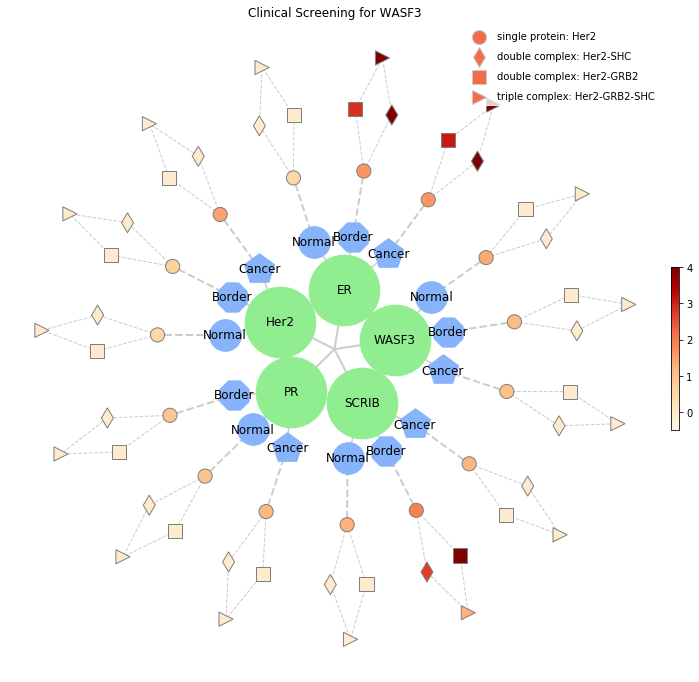

In [74]:
plot_for_one_patient()